# Time Series
- **Created by: Andrés Segura Tinoco**
- **Created on: July 09, 2020**

In [1]:
# Import Python libraries
import pandas as pd
import numpy as np
import itertools
import timeit
from scipy import stats
from math import pi, sqrt, ceil
from warnings import catch_warnings
from warnings import filterwarnings

In [2]:
# Import Parallel libraries
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

In [3]:
# Import Time Series libraries
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [4]:
# Import Plot libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Index
1. Visual Analytics
2. Base Line
3. Time Series Analysis
4. Box-Jenkins Analysis
5. Holt-Winters Analysis
6. Compare Models

#### Load full data

In [5]:
# Read raw data
data_url = "../data/dataset-monthly.csv"
rawdata = pd.read_csv(data_url, parse_dates=["date"], index_col=["date"])
rawdata['month_name'] = [d.strftime('%b') for d in rawdata.index]
rawdata

,year,month,value,month_name
date,,,,
2010-01-31,2010,1,3924.606,Jan
2010-02-28,2010,2,3711.240,Feb
2010-03-31,2010,3,4004.124,Mar
2010-04-30,2010,4,4034.857,Apr
2010-05-31,2010,5,4049.448,May
...,...,...,...,...
2019-08-31,2019,8,1281.637,Aug
2019-09-30,2019,9,1263.542,Sep
2019-10-31,2019,10,1583.655,Oct


## 1. Visual Analytics

### 1.1. Plot full data

In [6]:
# Create pretty x axis labels
def get_x_labels(all_labels):
    x_labels = []
    for ix in range(len(all_labels)):
        if ix % 5 == 0:
            date_label = str(all_labels[ix]).replace('T', '*').split('*')[0]
            x_labels.append(date_label)
        else:
            x_labels.append('')
    return x_labels

In [7]:
# Cooking weekly data
x_date = np.array(rawdata.index)
x_data = np.array(range(len(x_date))).reshape((-1, 1))
y_data = np.array(rawdata.value)
xticks = get_x_labels(x_date)
y_max = max(y_data) * 1.01

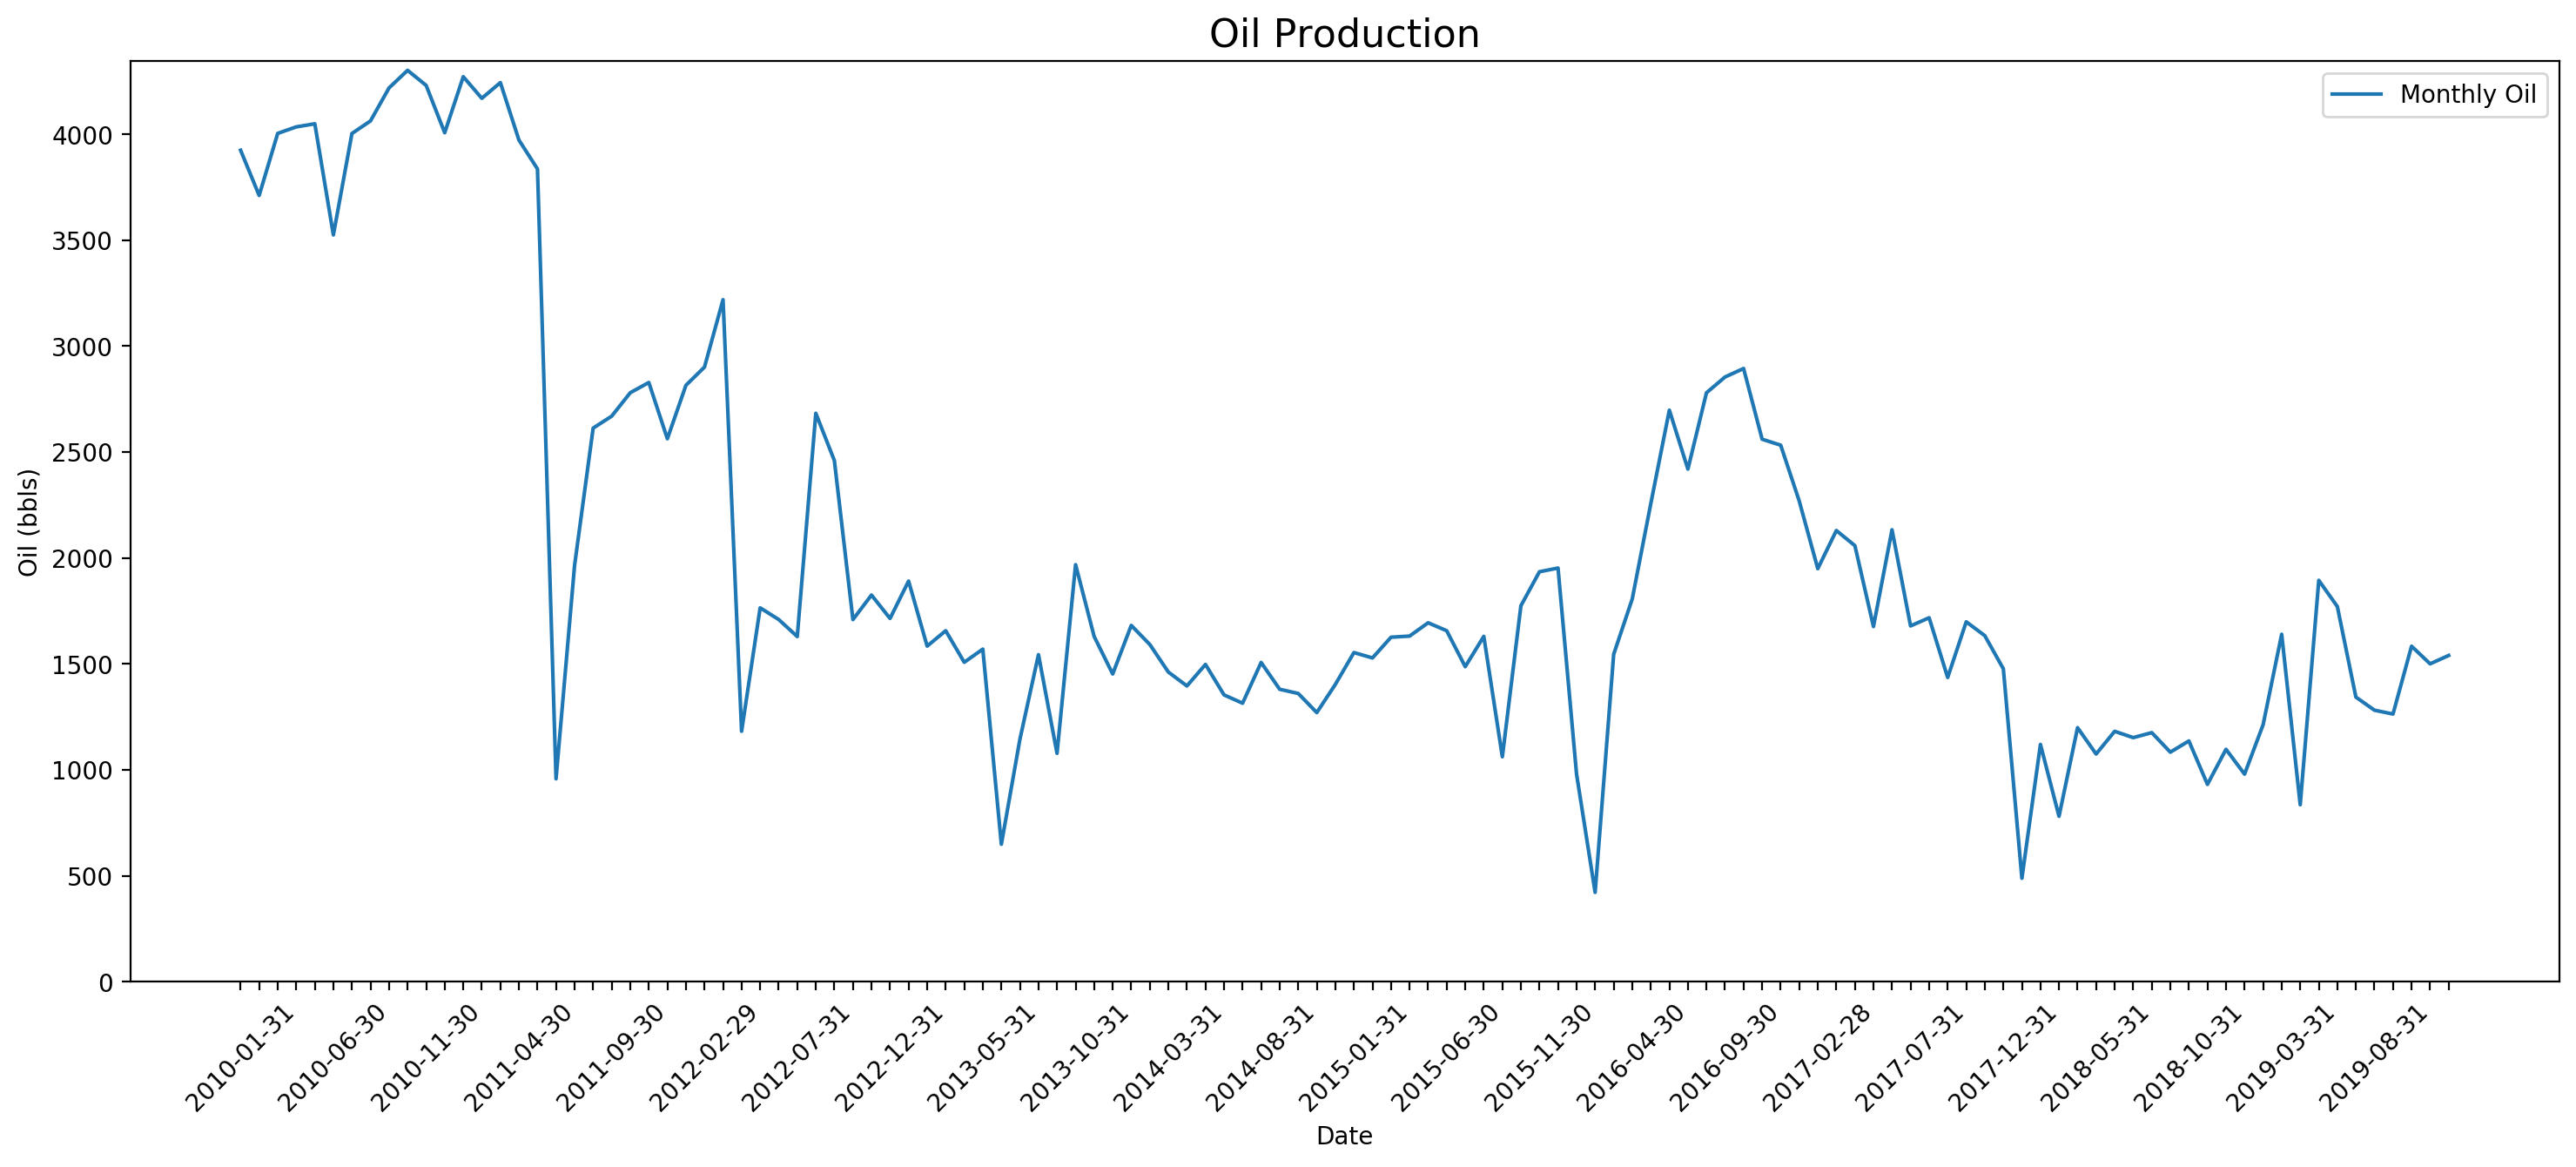

In [8]:
# Plot raw data
plt.figure(figsize=(18, 7), dpi=200)
plt.plot(x_data, y_data, label='Monthly Oil')
plt.ylim((0, y_max))
plt.title('Oil Production', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Oil (bbls)', fontsize=10)
plt.xticks(x_data, xticks, rotation=45)
plt.legend()
plt.show()

### 1.2. Data by year

In [9]:
# Grouping data by year
rawdata.groupby(['year'])['value'].agg('sum')

year
2010    48074.1040
2011    36871.6282
2012    25613.4690
2013    17675.6607
2014    17219.3350
2015    19531.8320
2016    25748.4345
2017    21859.2230
2018    12421.5391
2019    16846.8192
Name: value, dtype: float64

In [10]:
# Grouping data by Q1
rawdata[rawdata['month'].isin([1, 2])].groupby(['year'])['value'].agg('sum')

year
2010    7635.8460
2011    8441.3480
2012    5716.0940
2013    3475.2080
2014    3273.7190
2015    3081.9990
2016    1400.9755
2017    4218.7160
2018    1608.3686
2019    2193.0375
Name: value, dtype: float64

In [11]:
# Cooking data for year 2018
data_2018 = rawdata[rawdata['year'] == 2018]['value']
print('2018 Records: %s' % len(data_2018))
print('Total cases: %s' % sum(data_2018))
print('Average cases: %.2f' % np.mean(data_2018))
print('Median cases: %.2f' % np.median(data_2018))
print('Standard deviation: %.2f' % np.std(data_2018))

2018 Records: 12
Total cases: 12421.539100000002
Average cases: 1035.13
Median cases: 1108.57
Standard deviation: 200.33


In [12]:
# Cooking data for year 2019
data_2019 = rawdata[rawdata['year'] == 2019]['value']
print('2019 Records: %s' % len(data_2019))
print('Total cases: %s' % sum(data_2019))
print('Average cases: %.2f' % np.mean(data_2019))
print('Median cases: %.2f' % np.median(data_2019))
print('Standard deviation: %.2f' % np.std(data_2019))

2019 Records: 12
Total cases: 16846.819199999998
Average cases: 1403.90
Median cases: 1421.95
Standard deviation: 298.48


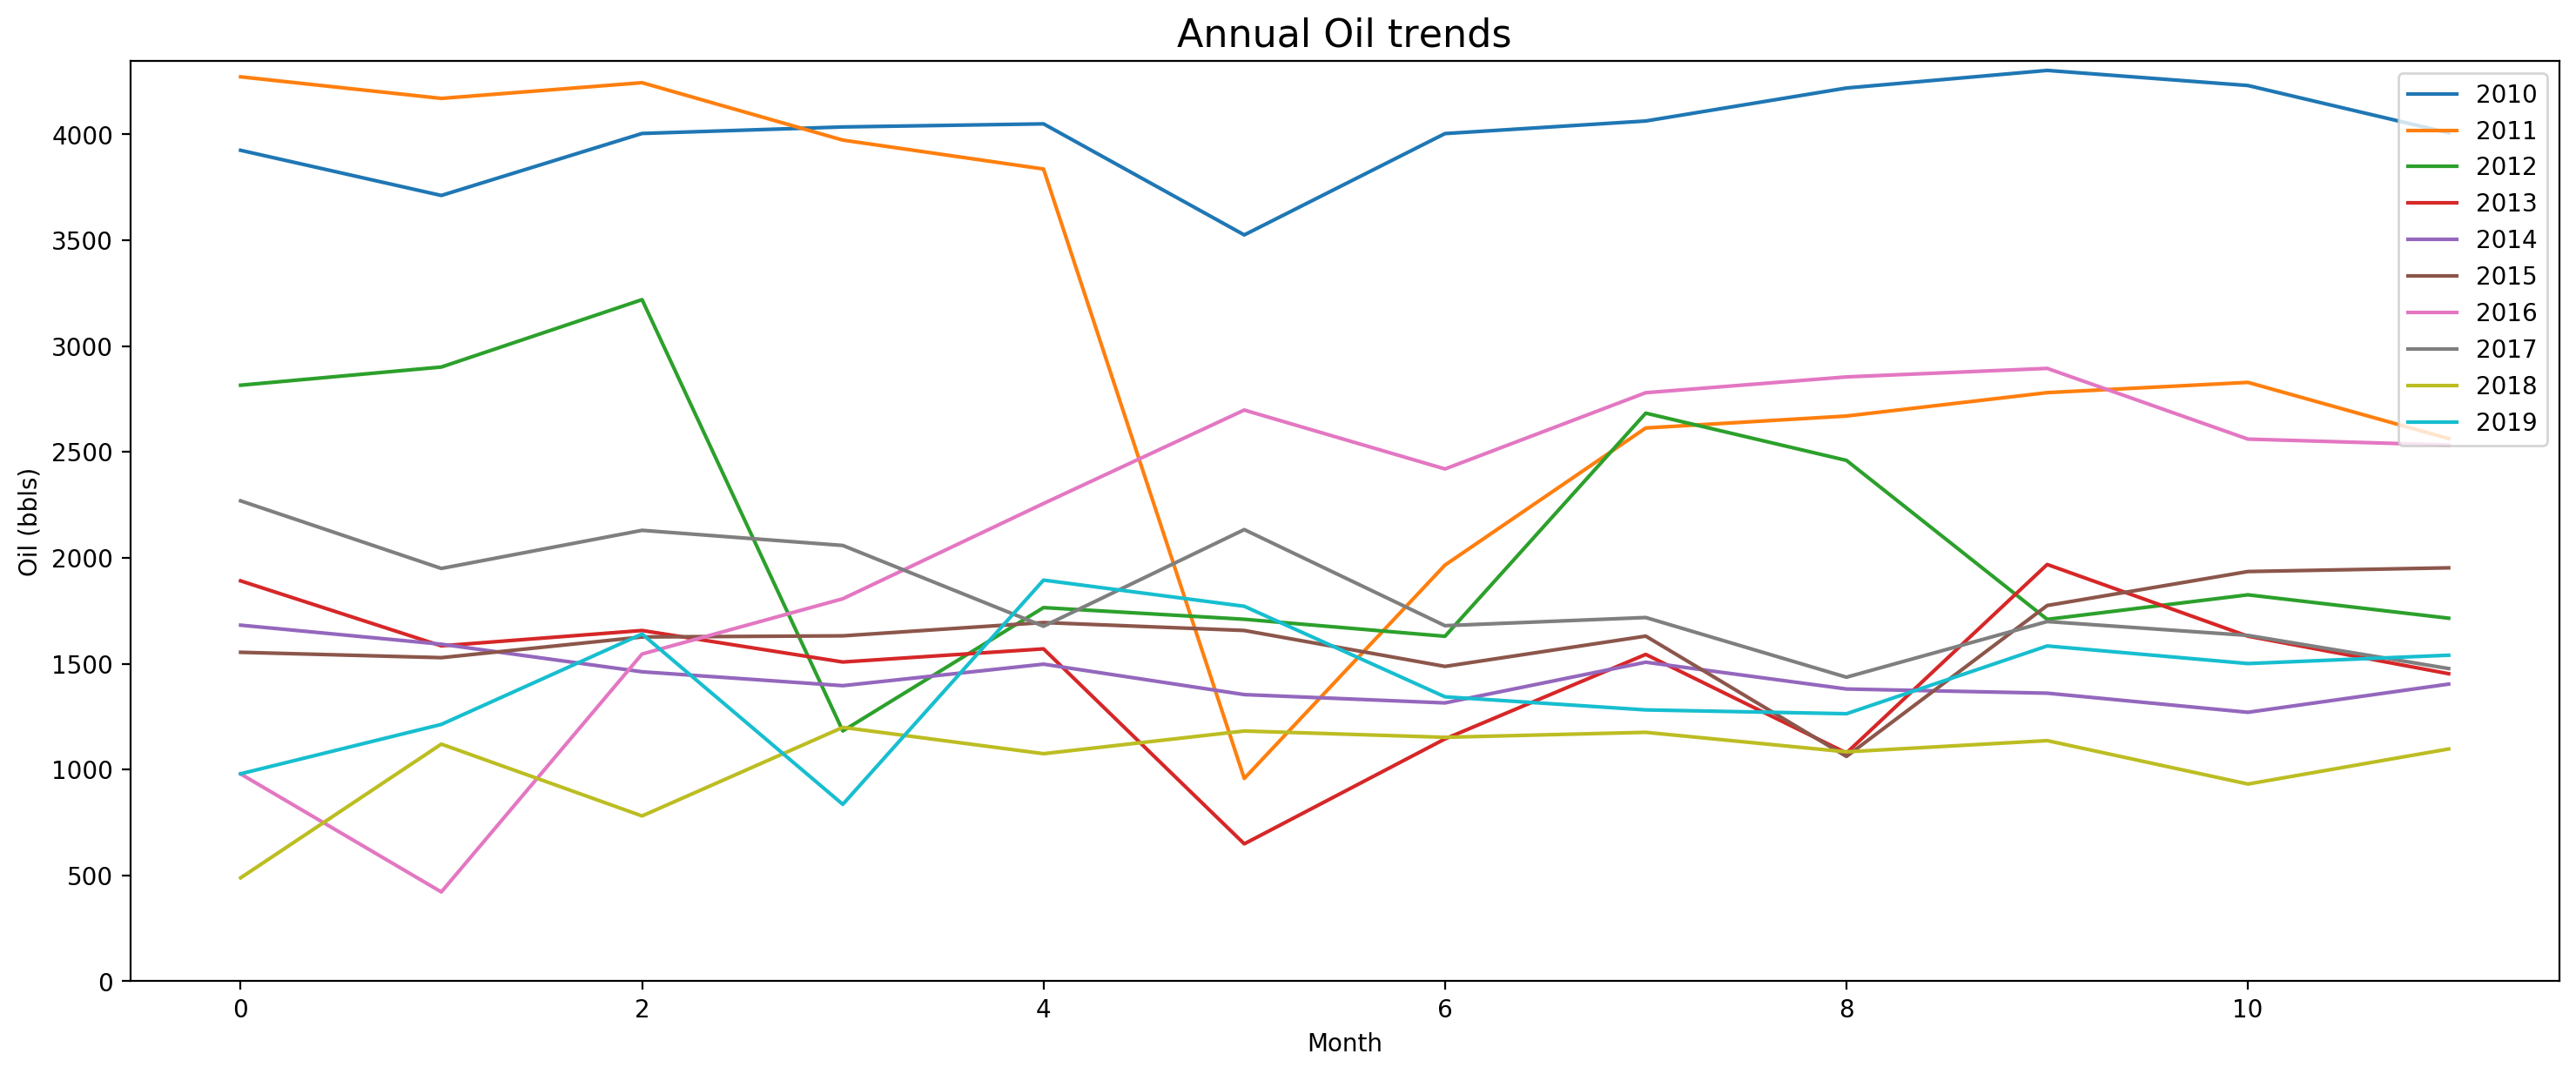

In [13]:
# Plot trends by year
plt.figure(figsize=(18, 7), dpi=200)
for i in range(2010, 2020):
    ts_data = rawdata[rawdata['year'] == i]['value']
    plt.plot(range(len(ts_data)), ts_data, label=i)
plt.ylim((0, y_max))
plt.title('Annual Oil trends', fontsize=16)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Oil (bbls)', fontsize=10)
plt.xticks(fontsize=10)
plt.legend(loc='upper right')
plt.show()

### 1.3. Check Month-wise (seasonal) and Year-wise (trend) distribution

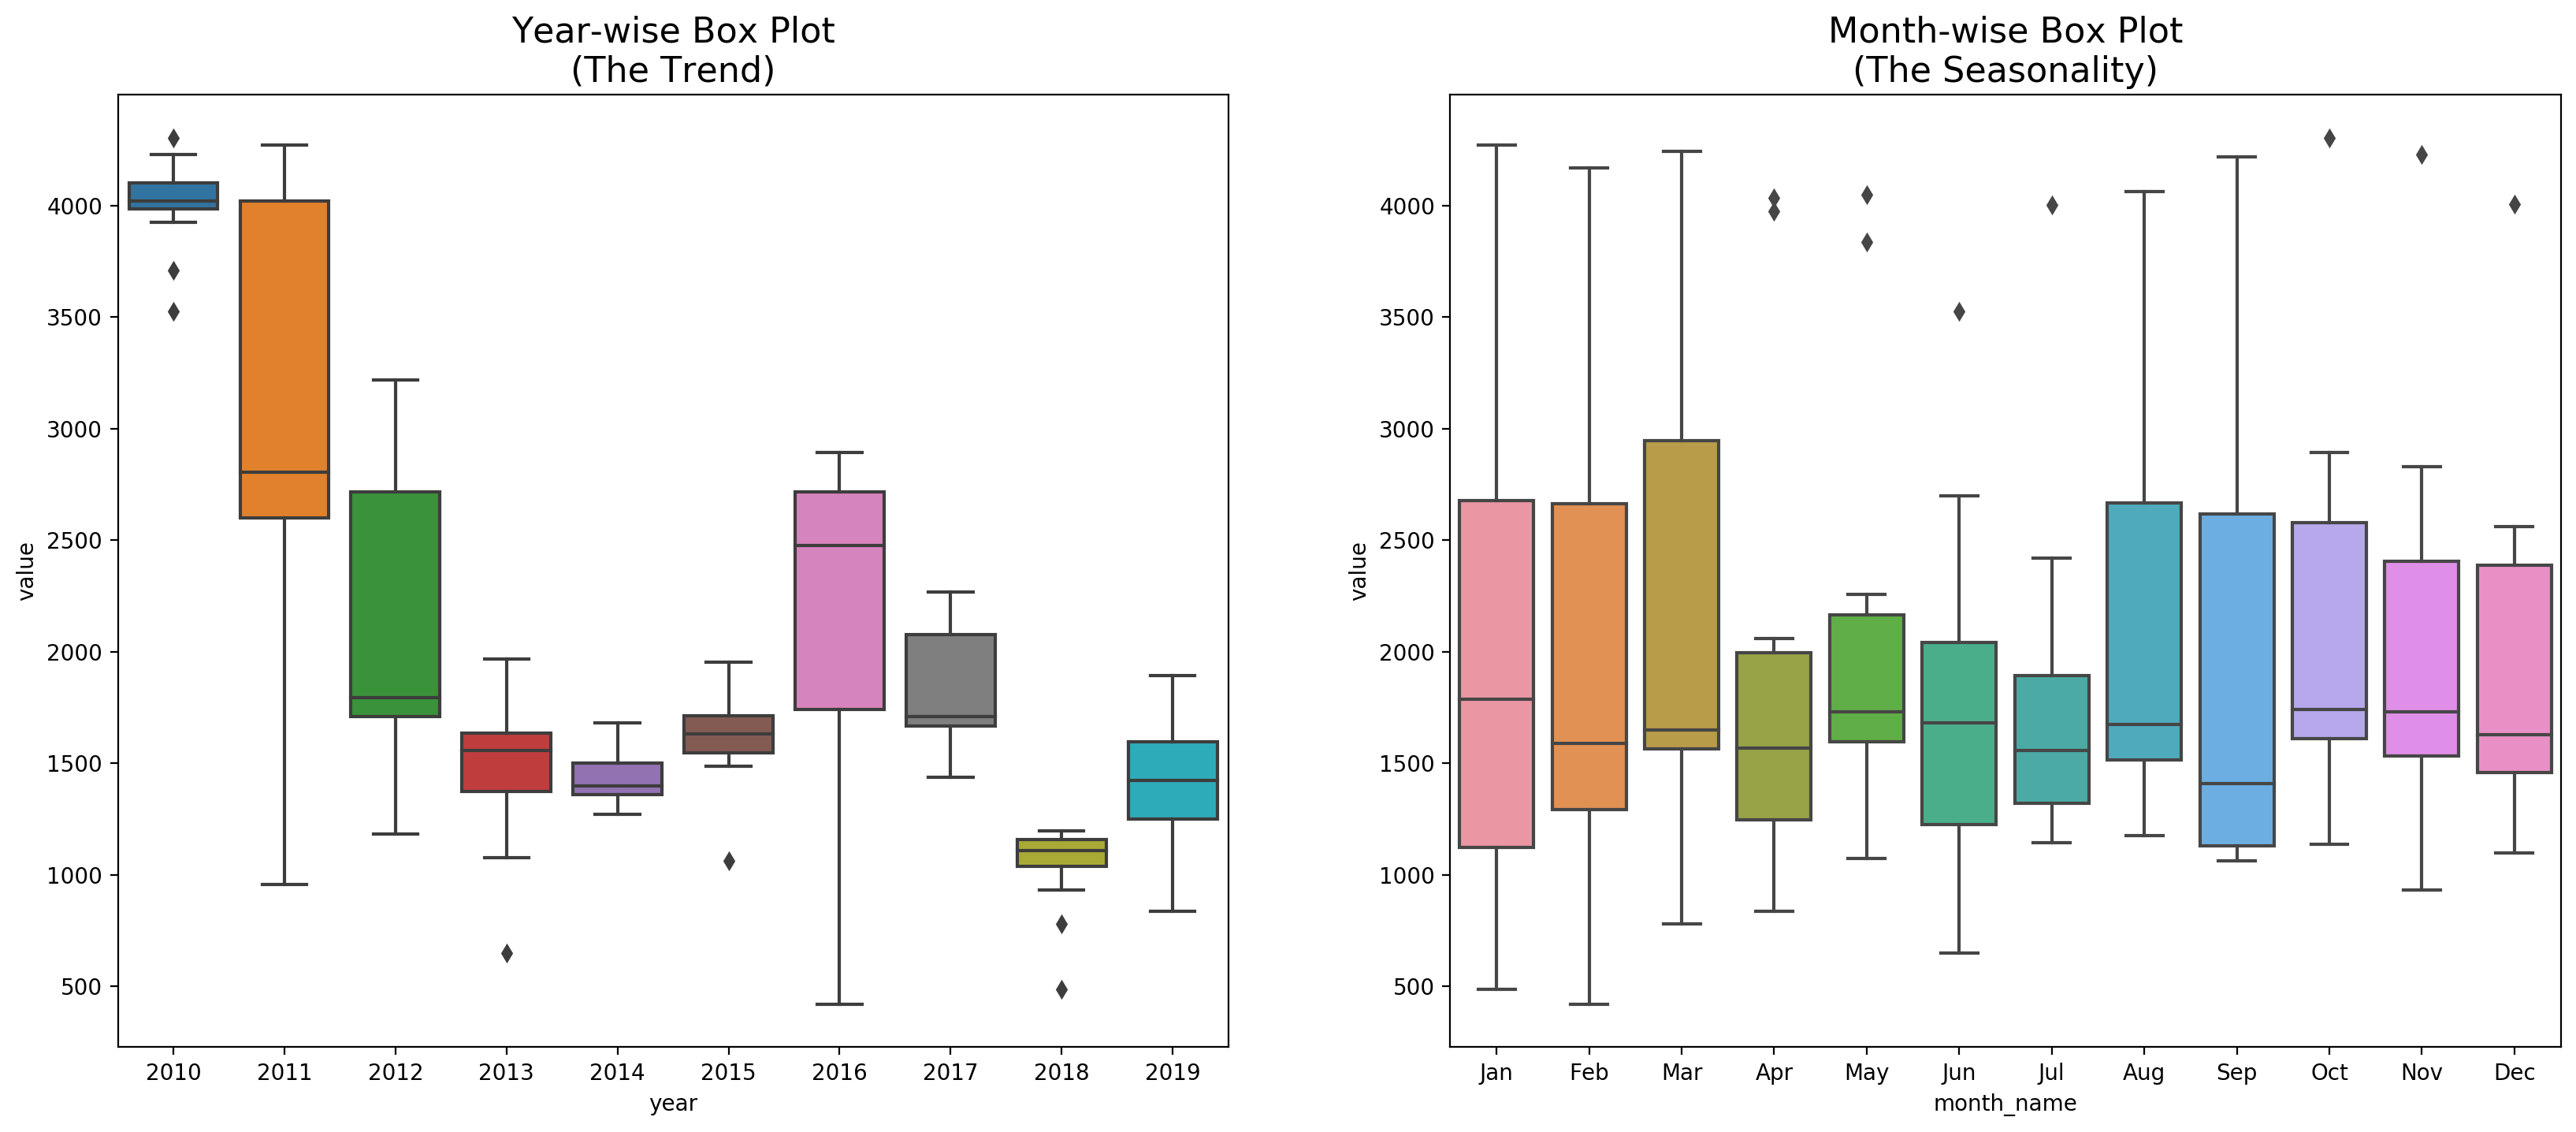

In [14]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi= 200)
sns.boxplot(x='year', y='value', data=rawdata, ax=axes[0])
sns.boxplot(x='month_name', y='value', data=rawdata, ax=axes[1])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=16); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=16)
plt.show()

#### Result
The dataset contains an obvious trend but no obvious seasonal component.

## 2. Base Line

The error validation functions are defined:

In [15]:
# Calculate root mean squared error or RMSE
def calc_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [16]:
# Calculate mean absolute percentage error or MAPE
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def calc_mape(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [17]:
# Calculate confidence interval
def get_interval(y, y_pred, pi=0.99):
    n = len(y)
    
    # Get standard deviation of y_test
    sum_errs = np.sum((y - y_pred)**2) / (n - 2)
    stdev = np.sqrt(sum_errs)
    
    # Get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
    return interval

### 2.1. Linear Regression

In [18]:
# Create model LR
degree = 4
x_ = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(x_data)
model = LinearRegression().fit(x_, y_data)

# Validate model
r_sq = model.score(x_, y_data)
print('Correlation:', sqrt(r_sq))
print('Coefficient of determination:', r_sq)
print('Intercept:', model.intercept_, ', Slope:', model.coef_)

Correlation: 0.8279770071935177
Coefficient of determination: 0.6855459244411345
Intercept: 4716.559836760295 , Slope: [-1.36349357e+02  1.85743880e+00 -7.13162161e-03 -8.94050006e-06]


In [19]:
# Prediction
y_pred = model.predict(x_)

# Calculate errors
rmse = calc_rmse(y_data, y_pred)
mape = calc_mape(y_data, y_pred)
print('The RMSE of our forecasts is: {}'.format(round(rmse, 3)))
print('The MAPE of our forecasts is: {} %'.format(round(mape, 3)))

The RMSE of our forecasts is: 550.657
The MAPE of our forecasts is: 27.962 %


In [20]:
ci_alpha = 0.9
ci = get_interval(y_data, y_pred, ci_alpha)
print('Conf. Int.:', ci)

Conf. Int.: 913.3934004716266


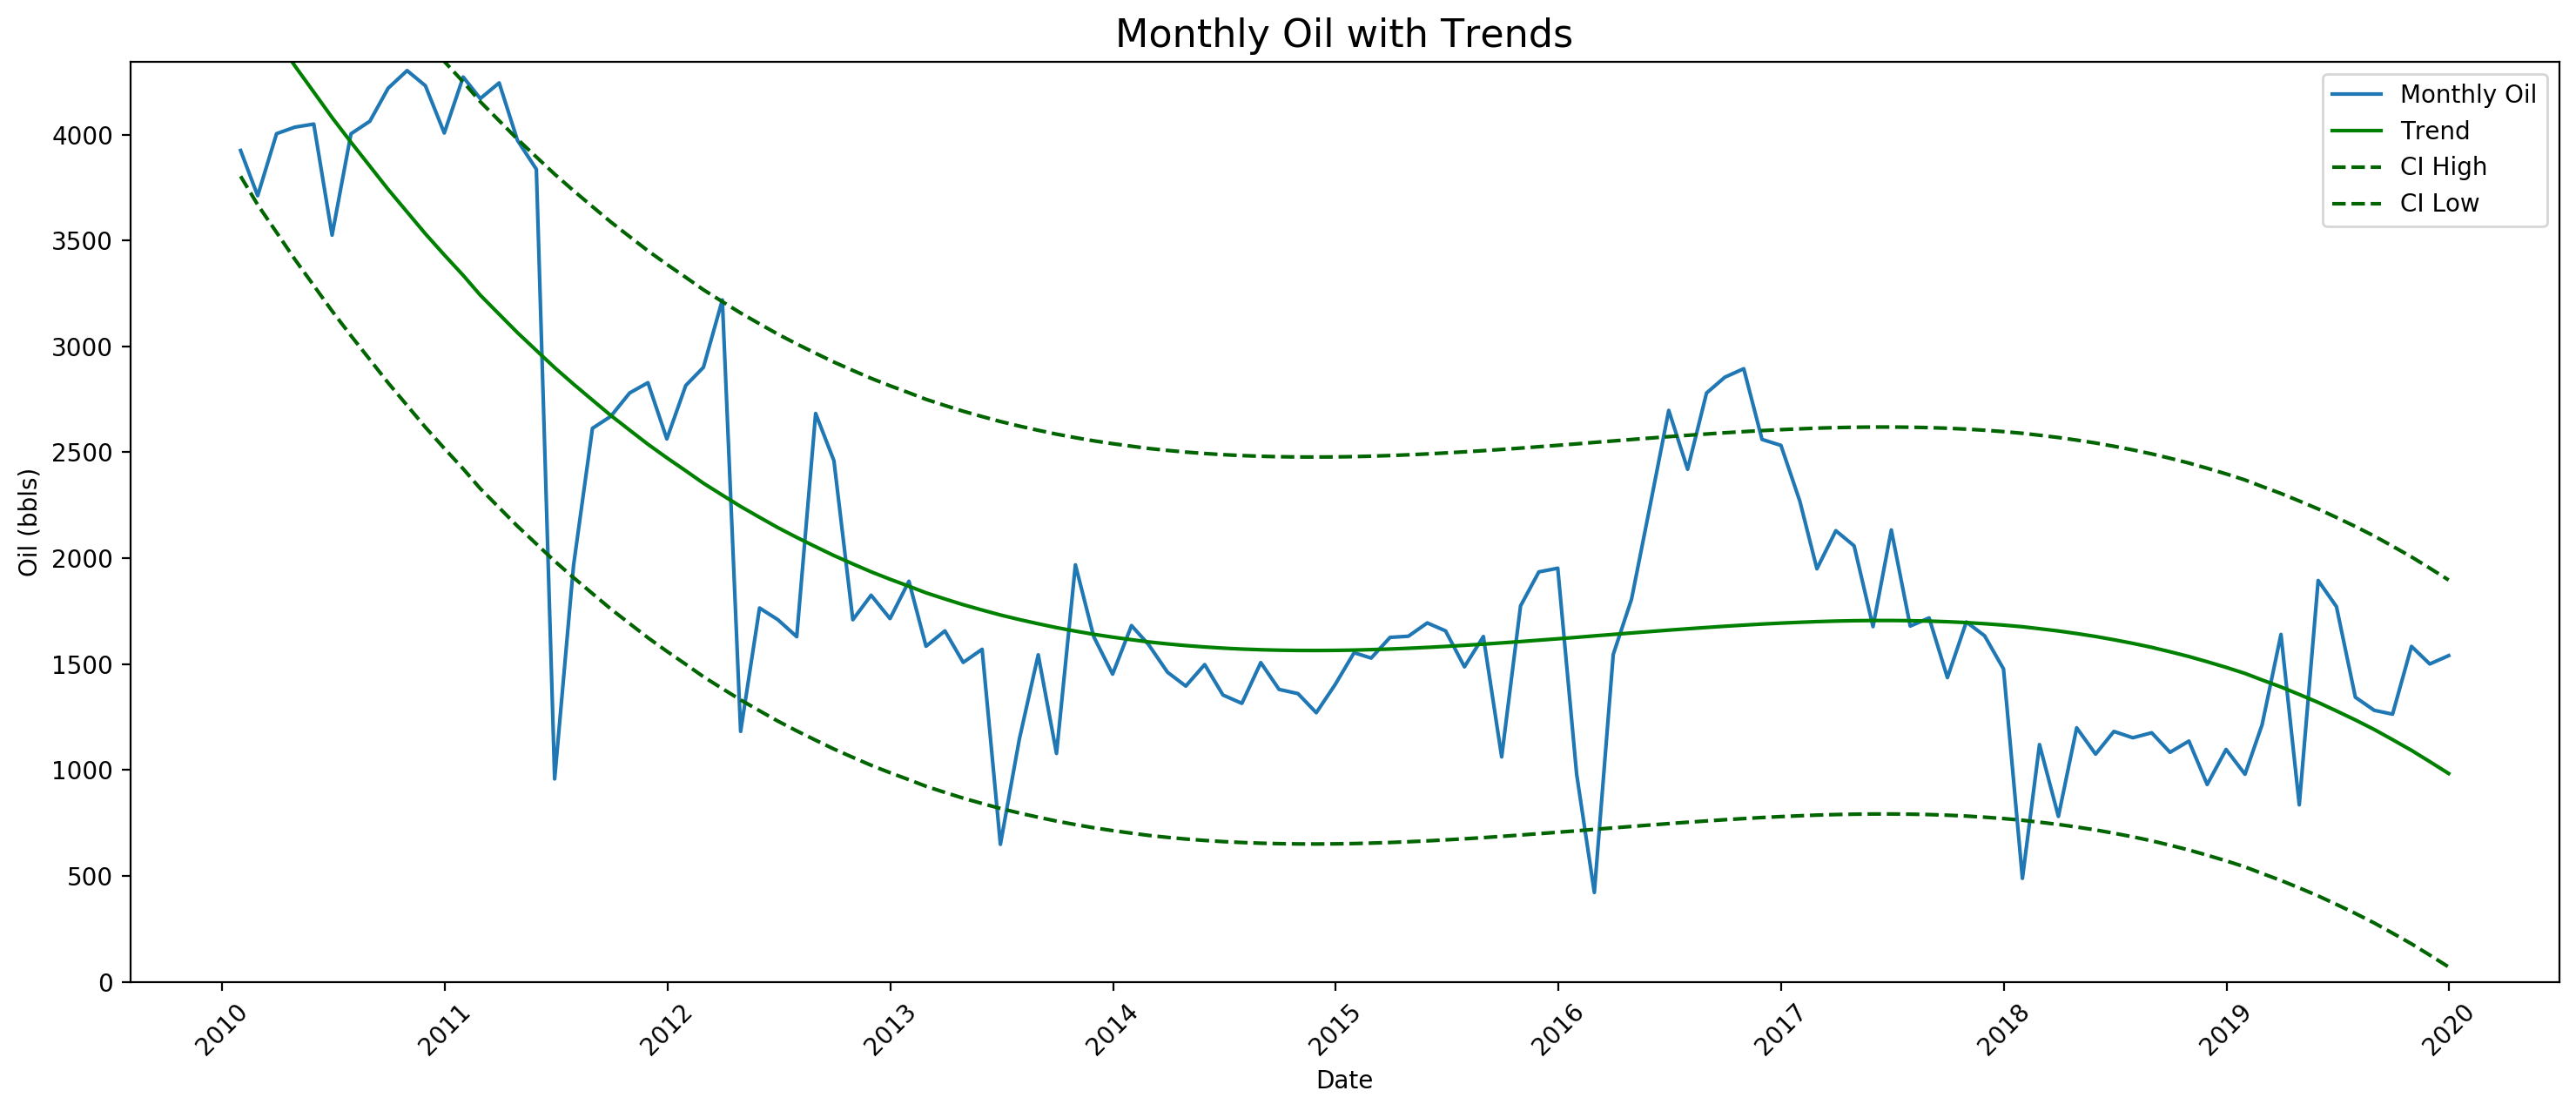

In [21]:
# Plot chart
plt.figure(figsize=(18, 7), dpi=200)
plt.plot(x_date, y_data, '-', label='Monthly Oil')
plt.plot(x_date, y_pred, '-', color='green', label='Trend')
plt.plot(x_date, y_pred + ci, '--', color='darkgreen', label='CI High')
plt.plot(x_date, y_pred - ci, '--', color='darkgreen', label='CI Low')
plt.ylim((0, y_max))
plt.title('Monthly Oil with Trends', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Oil (bbls)', fontsize=10)
plt.xticks(fontsize=10, rotation=45)
plt.legend()
plt.show()

#### Result
- RMSE: 550.657
- MAPE: 27.962 %

## 3. Time Series Analysis

In [22]:
# Control param for SARIMA and Holt-Winters methods
perc_test = 0.10
data_freq = 12
n_forecast = 12
run_fit = False

In [23]:
# Cooking time-series data with frequency
series_data = rawdata['value']
series_data = series_data.asfreq(freq='M')
series_data

date
2010-01-31    3924.606
2010-02-28    3711.240
2010-03-31    4004.124
2010-04-30    4034.857
2010-05-31    4049.448
                ...   
2019-08-31    1281.637
2019-09-30    1263.542
2019-10-31    1583.655
2019-11-30    1500.468
2019-12-31    1539.903
Freq: M, Name: value, Length: 120, dtype: float64

### 3.1. Statistical tests for stationarity

In a stationary **time series**, statistical properties such as mean and variance are constant over time. In a non-stationary series, these properties are dependent on time.

Augmented Dickey-Fuller unit root test:
- Tests for trend non-stationarity.
- Null hypothesis ($H_0$) is time series is non-stationary.

In [24]:
adf_results = adfuller(series_data)
print('ADF Statistic:', adf_results[0])
print('p-value:', adf_results[1])

ADF Statistic: -2.5306414461601836
p-value: 0.1081957974006682


In [25]:
adf_results = adfuller(series_data.diff().dropna())
print('ADF Statistic:', adf_results[0])
print('p-value:', adf_results[1])

ADF Statistic: -4.000514157133124
p-value: 0.001407821367155071


#### Result
- Based on ADF test statistic and p-value the time series is non-stationary. We fail to reject the null hypothesis.
- However, the first difference in the time series itself is stationary.

### 3.2. Correlation and autocorrelation

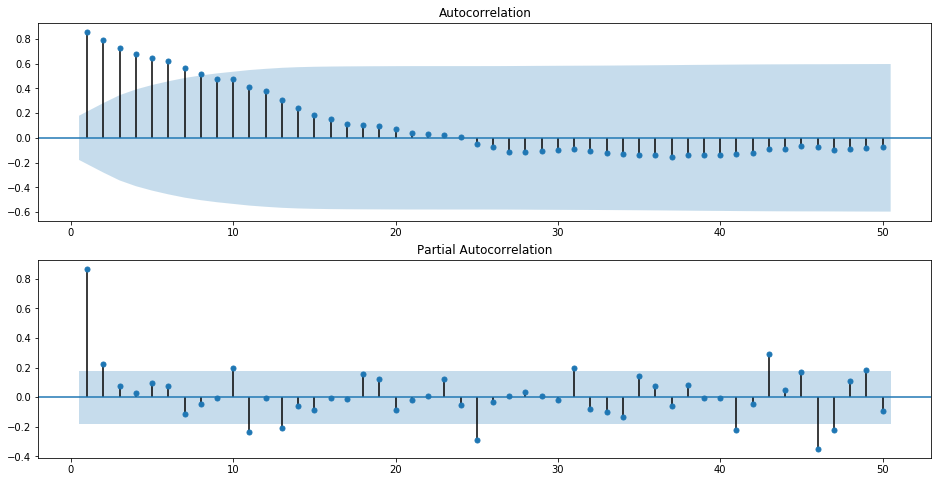

In [26]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))
plot_acf(series_data, lags=50, zero=False, ax=ax1)
plot_pacf(series_data, lags=50, zero=False, ax=ax2)
plt.show()

#### Result
We can use a $p = 2$.

### 3.3. Check seasonal decomposition

These components are defined as follows:
- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

#### 3.3.1. Additive decomposition
Additive series = Level + Trend + Seasonality + Noise

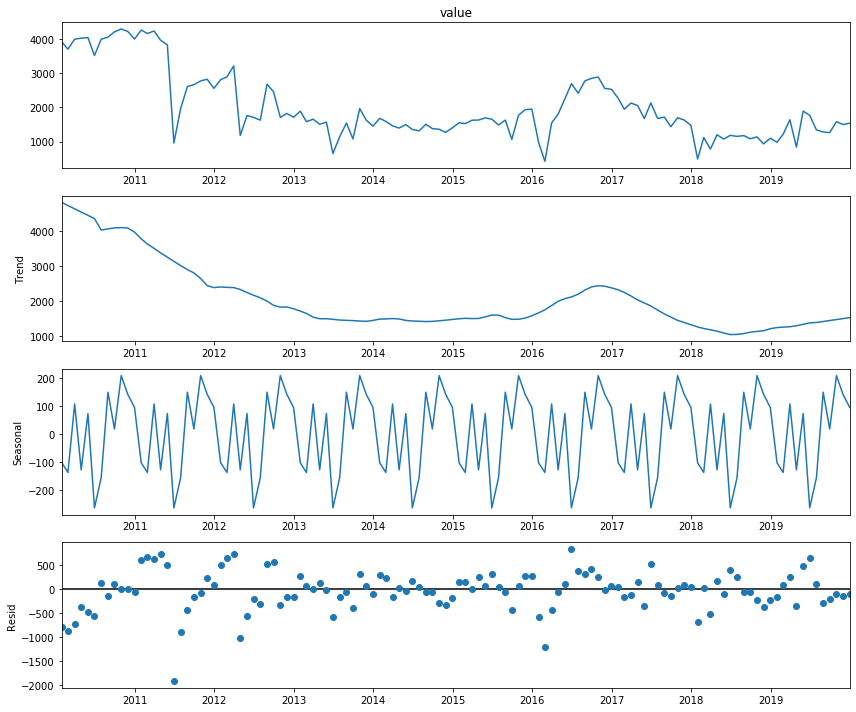

In [27]:
# Additive Decomposition
result_add = seasonal_decompose(series_data, model='additive', extrapolate_trend='freq')

# Show Additive Decompose
plt.rcParams.update({'figure.figsize': (12, 10)})
result_add.plot()
plt.show()

#### 3.3.2. Multiplicative decomposition
Multiplicative series = Level x Trend x Seasonality x Noise

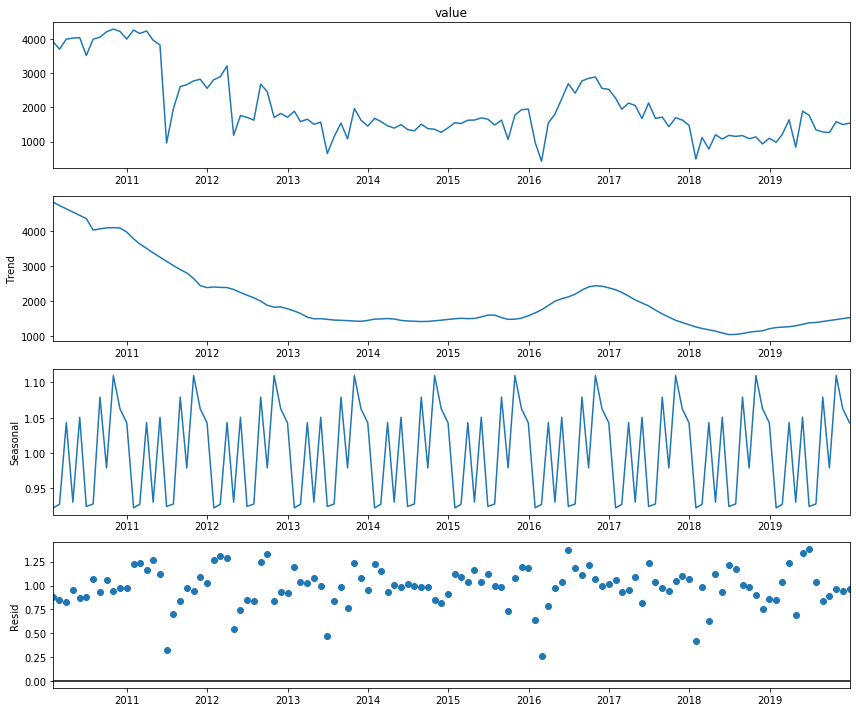

In [28]:
# Multiplicative Decomposition
result_add = seasonal_decompose(series_data, model='multiplicative', extrapolate_trend='freq')

# Show Additive Decompose
plt.rcParams.update({'figure.figsize': (12, 10)})
result_add.plot()
plt.show()

#### Result
Both the additive and multiplicative models have the following properties:
- Clear decreasing trend.
- It's a seasonal time series.
- The residuals oscillate around 0

## 4. Box-Jenkins Analysis

In time series analysis, the Box–Jenkins method, applies autoregressive moving average (ARMA) or autoregressive integrated moving average (ARIMA) models to find the best fit of a time-series model to past values of a time series.

### 4.1. Select best parameters for SARIMA model

AIC - Akaike information criterion
- Lower AIC indicates a better model
- AIC likes to choose simple models with lower order

BIC - Bayesian information criterion
- Very similar to AIC
- Lower BIC indicates a better model
- BIC likes to choose simple models with lower order

In [29]:
# Create a set of SARIMA configs to try
def arima_smoothing_configs():
    
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 3)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq  = [(x[0], x[1], x[2], data_freq) for x in list(itertools.product(p, d, q))]
    
    return pdq, seasonal_pdq

In [30]:
# Parameter Selection for the ARIMA Time Series Model
def arima_grid_search(pdq, seasonal_pdq):
    start_time = timeit.default_timer()
    
    # Specify to ignore warning messages
    filterwarnings("ignore")
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(series_data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()

                print('SARIMA: {} x {}, AIC:{}, BIC:{}'.format(param, param_seasonal, results.aic, results.bic))
            except:
                # Print AIC and BIC as None when fails
                print('SARIMA: {} x {}, AIC:{}, BIC:{}'.format(param, param_seasonal, None, None))
    
    # Elapsed time
    elapsed = timeit.default_timer() - start_time
    print('Elapsed time', elapsed, 's')

#### Run the grid search

In [31]:
# Run ARIMA fit
if run_fit:
    
    # Calculation params
    pdq, seasonal_pdq = arima_smoothing_configs()
    
    # Run grid search
    arima_grid_search(pdq, seasonal_pdq)
    print('Done SARIMA method')

### 4.2. Create SARIMA model

- Prob(Q) - p-value for null hypothesis that residuals are uncorrelated
- Prob(JB) - p-value for null hypothesis that residuals are normal

In [32]:
# Fitting a SARIMA Time Series model
filterwarnings("ignore")
model = sm.tsa.statespace.SARIMAX(series_data, order=(0, 1, 2), seasonal_order=(0, 0, 1, data_freq), 
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()

In [33]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                  120
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 12)   Log Likelihood                -790.418
Date:                              Thu, 09 Jul 2020   AIC                           1588.837
Time:                                      16:58:47   BIC                           1599.414
Sample:                                  01-31-2010   HQIC                          1593.122
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3927      0.139     -2.830      0.005      -0.665      -0.121
ma.L2         -0.17

#### Plot diagnostics

If the model fits well the residuals will be white Gaussian noise.

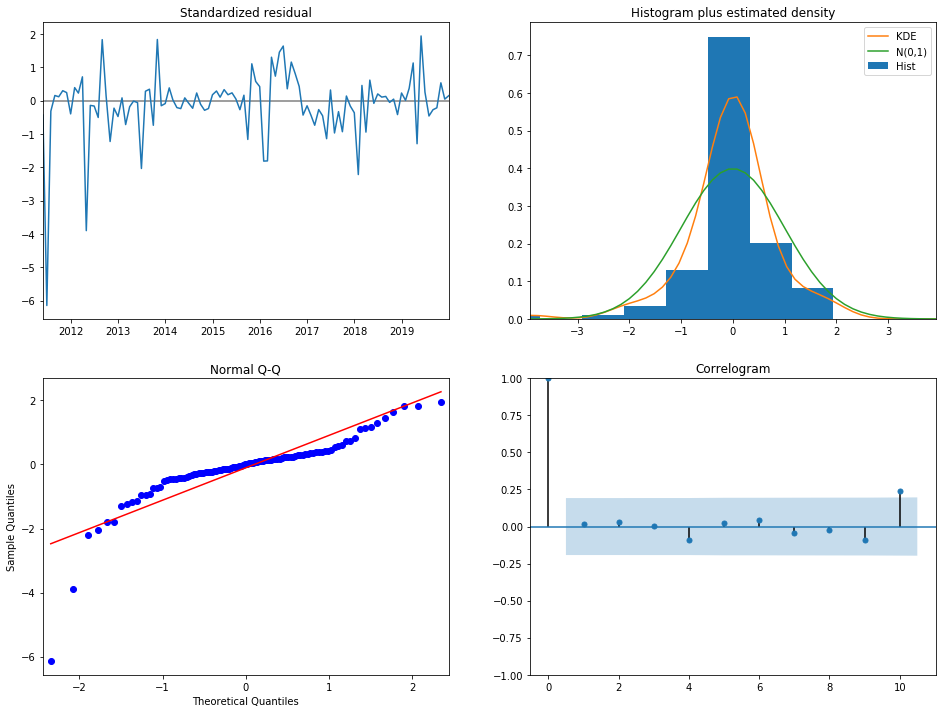

In [34]:
model.plot_diagnostics(figsize=(16, 12))
plt.show()

### 4.3. Validating SARIMA forecasts

In [35]:
# Start prediction from...
ix_test = ceil(len(series_data) * (1 - perc_test))
start_date = str(series_data.index[ix_test])
ix_test, start_date

(108, '2019-01-31 00:00:00')

#### 4.3.1. Validate prediction with dynamic False

In [36]:
# Validate prediction with dynamic False
pred = model.get_prediction(start=start_date, dynamic=False)
pred_ci = pred.conf_int(alpha=1-ci_alpha)

# Show predictions
y_forecasted = pd.Series(np.array([round(p) for p in pred.predicted_mean]), pred.predicted_mean.index)
y_forecasted

date
2019-01-31     974
2019-02-28    1036
2019-03-31    1102
2019-04-30    1448
2019-05-31     971
2019-06-30    1648
2019-07-31    1561
2019-08-31    1410
2019-09-30    1364
2019-10-31    1328
2019-11-30    1477
2019-12-31    1468
Freq: M, dtype: int32

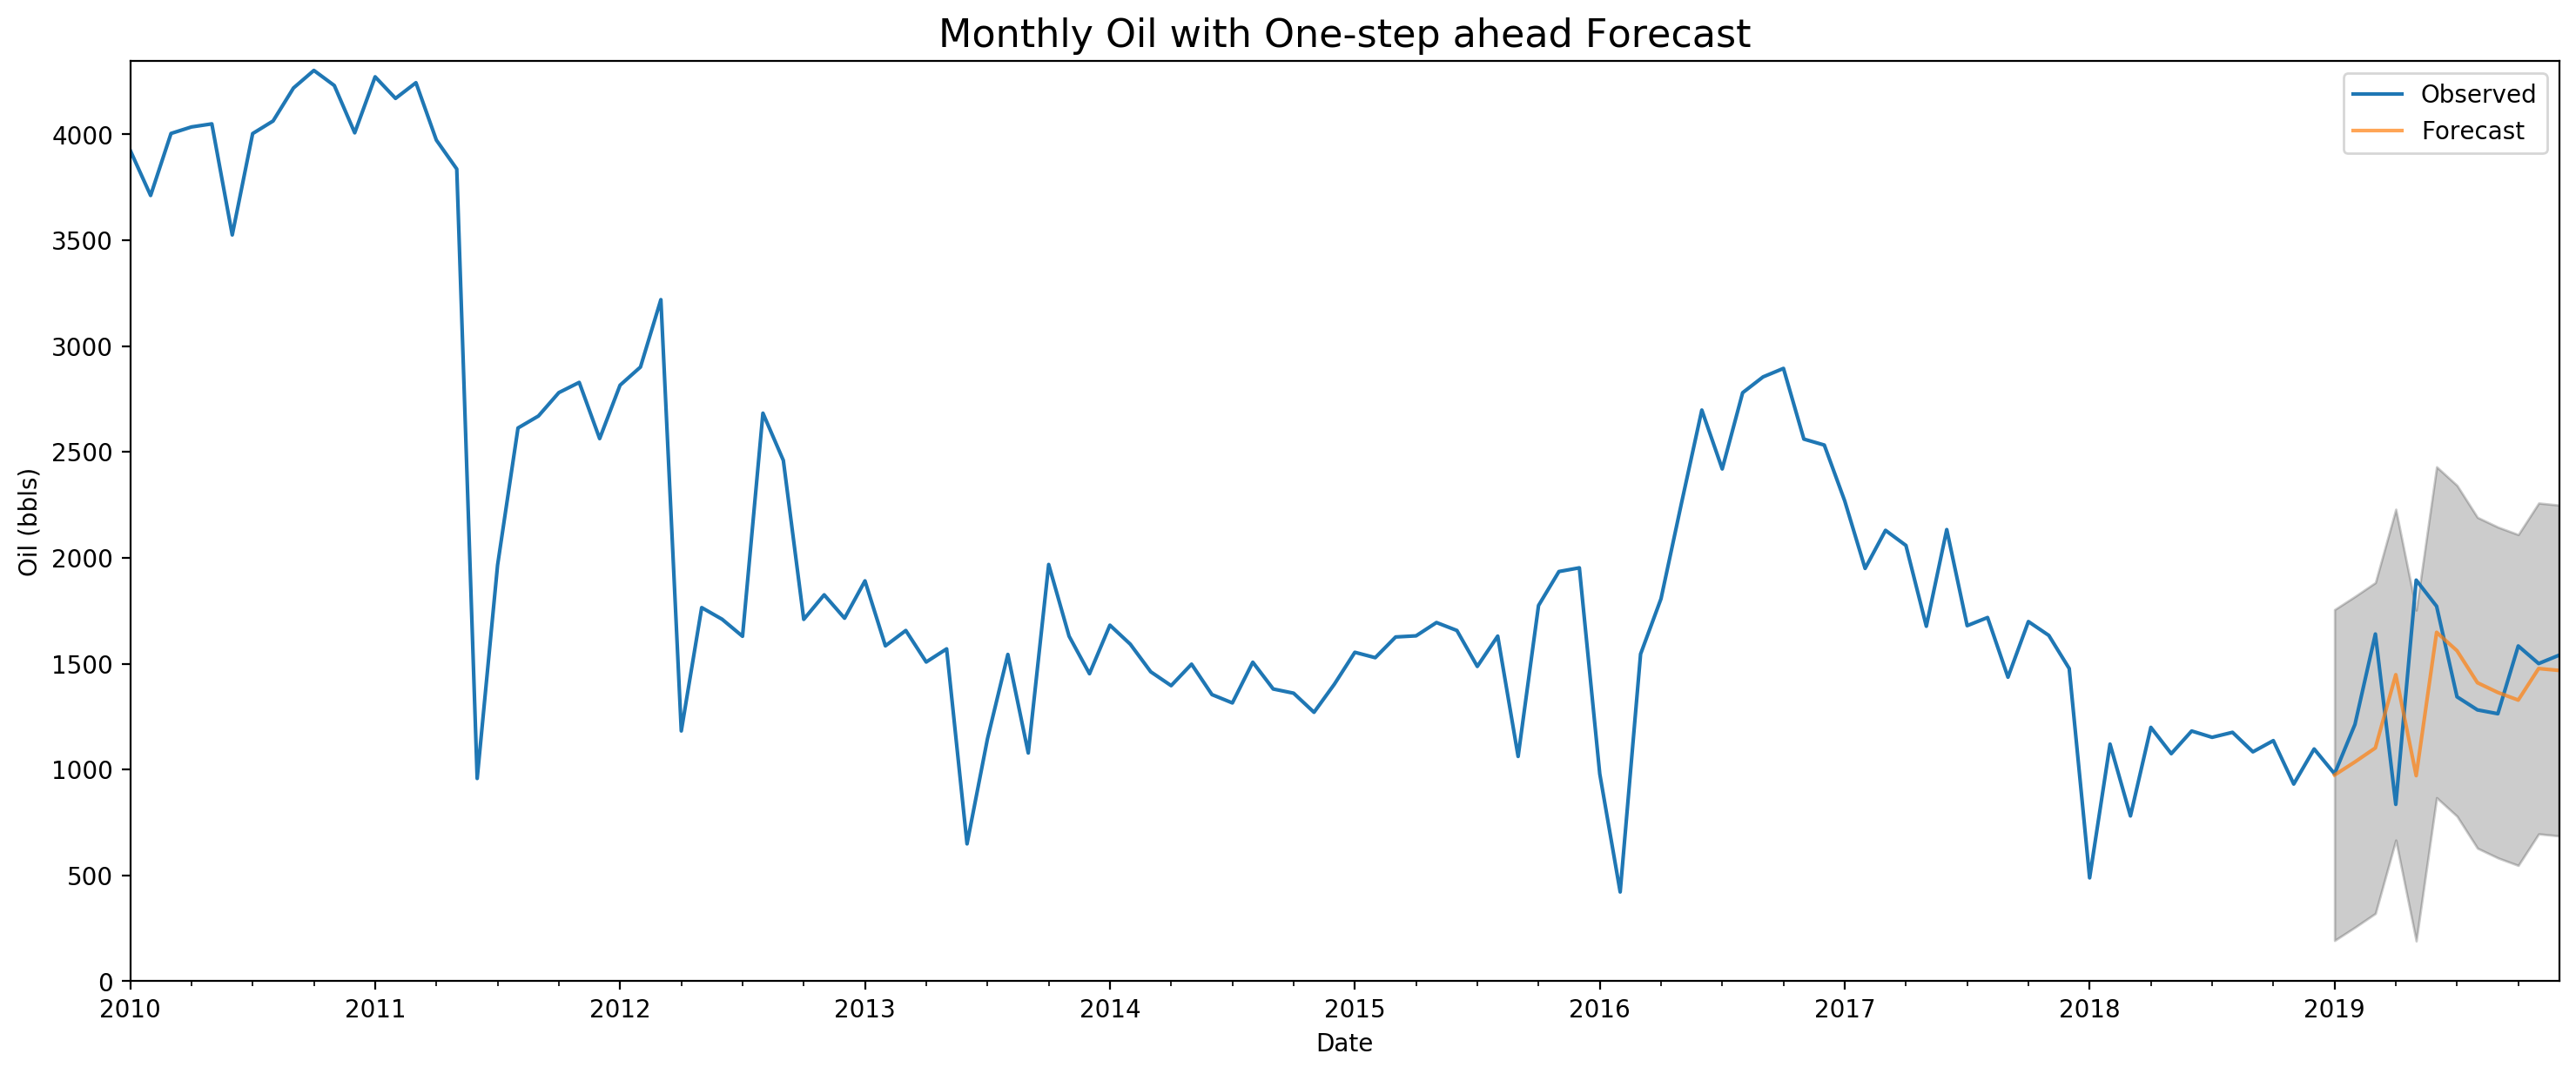

In [37]:
# Plot results
plt.figure(figsize=(18, 7), dpi=200)
ax = series_data.plot(label='Observed')
y_forecasted.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.ylim((0, y_max))
plt.title('Monthly Oil with One-step ahead Forecast', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Oil (bbls)', fontsize=10)
plt.legend()
plt.show()

In [38]:
# Extract the predicted and true values of our time series
y_truth = series_data[start_date:]

# Compute the errors
rmse = calc_rmse(y_truth, y_forecasted)
mape = calc_mape(y_truth, y_forecasted)
print('The RMSE of our forecasts is: {}'.format(round(rmse, 3)))
print('The MAPE of our forecasts is: {} %'.format(round(mape, 3)))

The RMSE of our forecasts is: 377.41
The MAPE of our forecasts is: 19.463 %


#### 4.3.2. Validate prediction with dynamic True

In [39]:
# Predict
pred_dynamic = model.get_prediction(start=start_date, dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int(alpha=1-ci_alpha)

# Show predictions
y_forecasted = pd.Series(np.array([round(p) for p in pred_dynamic.predicted_mean]), pred_dynamic.predicted_mean.index)
y_forecasted

date
2019-01-31     974
2019-02-28    1033
2019-03-31     992
2019-04-30    1043
2019-05-31    1034
2019-06-30    1041
2019-07-31    1044
2019-08-31    1046
2019-09-30    1040
2019-10-31    1042
2019-11-30    1018
2019-12-31    1040
Freq: M, dtype: int32

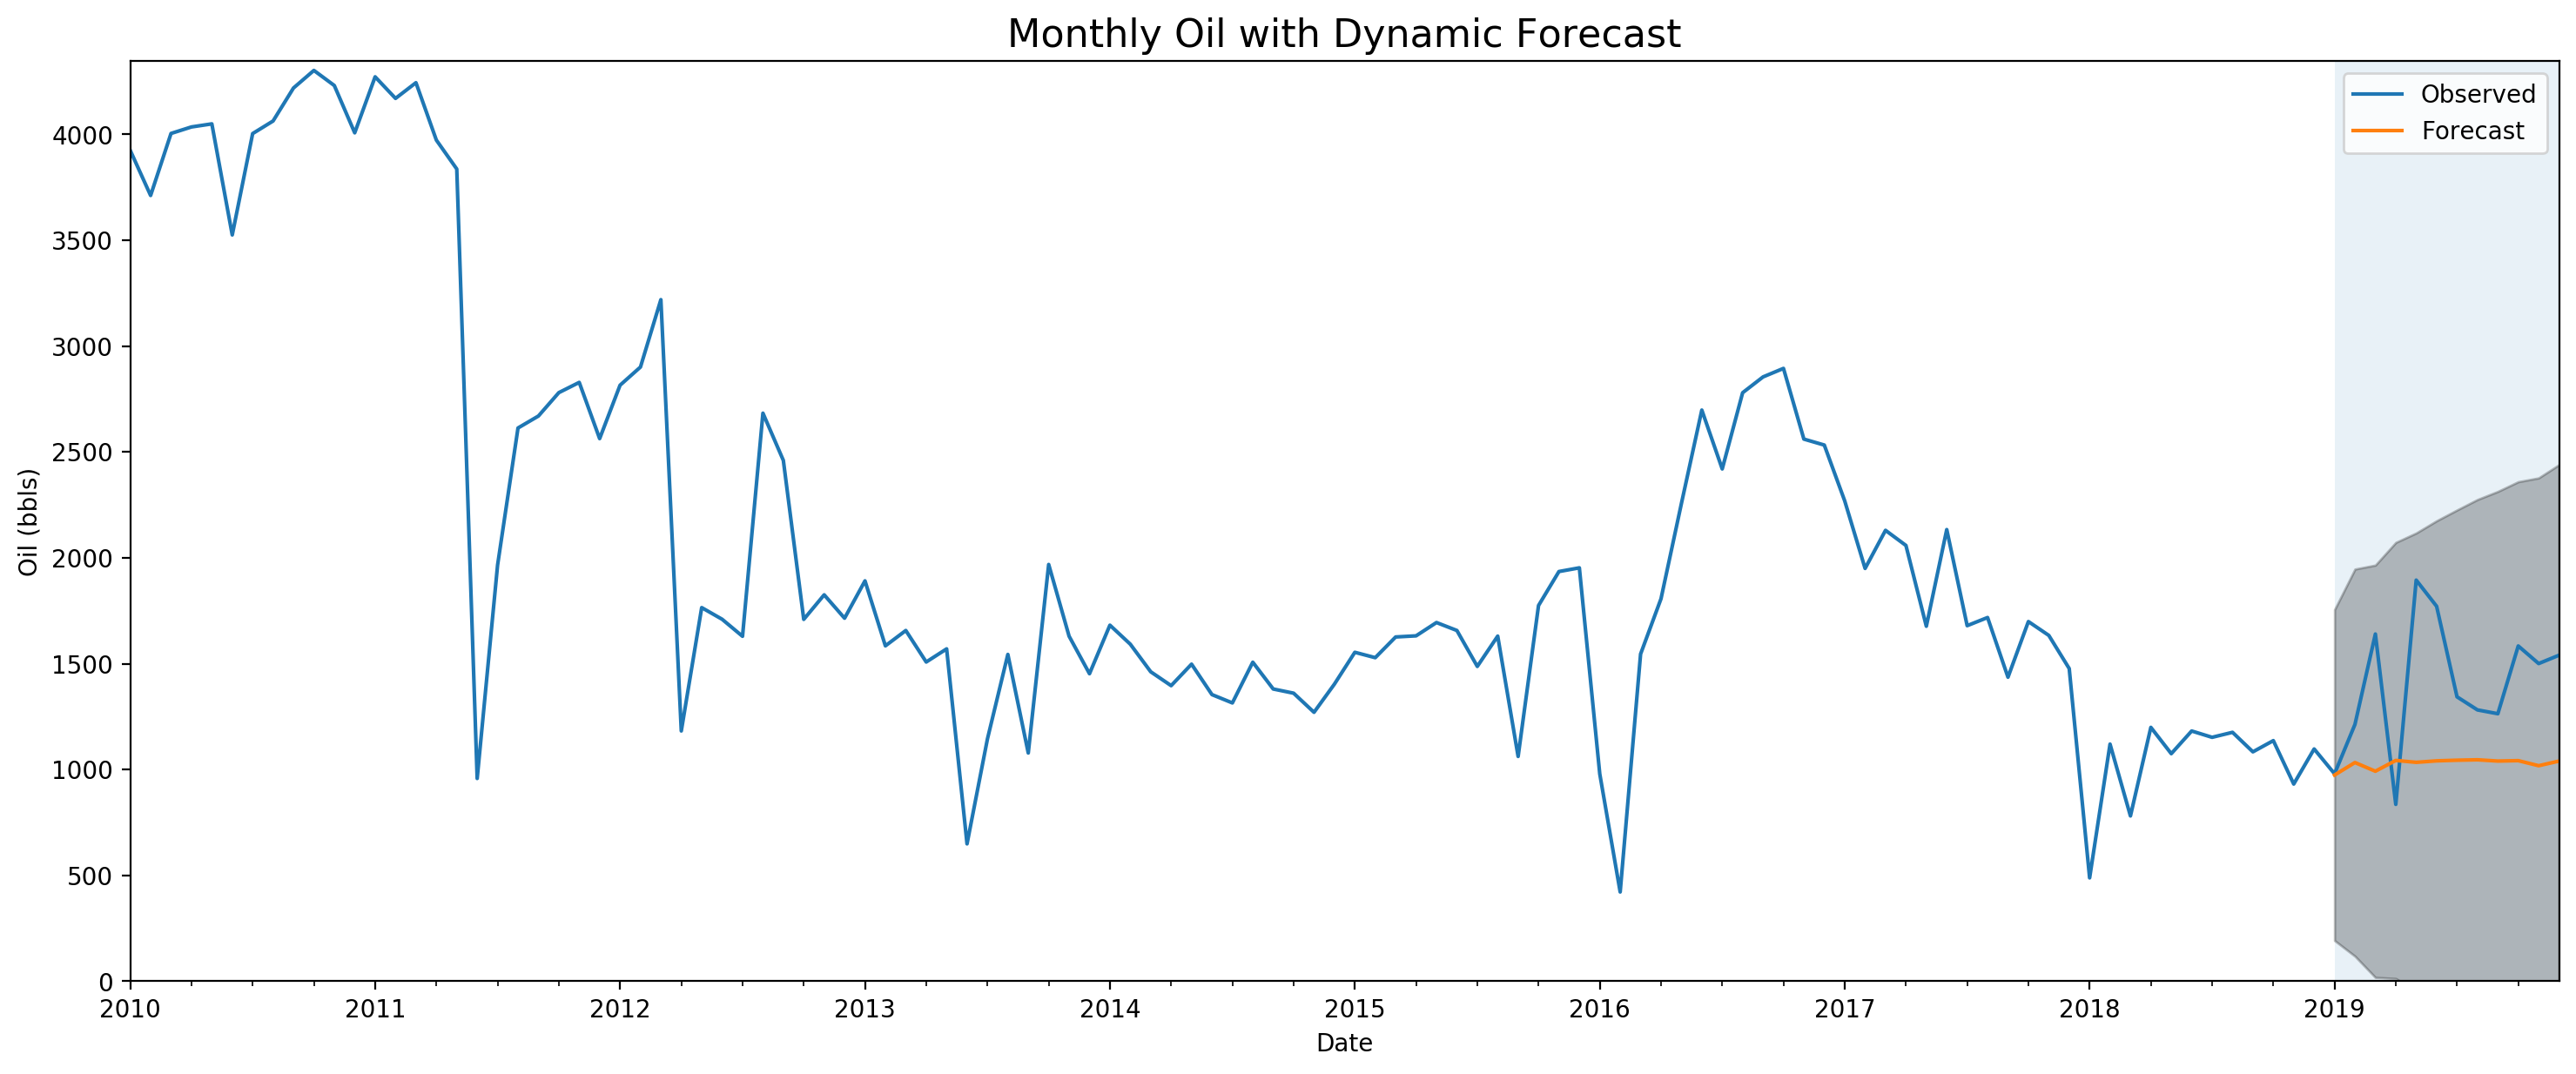

In [40]:
# Plot results
plt.figure(figsize=(18, 7), dpi=200)
ax = series_data.plot(label='Observed')
y_forecasted.plot(label='Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pred_dynamic_ci.index[0], pred_dynamic_ci.index[-1], alpha=.1, zorder=-1)
plt.ylim((0, y_max))
plt.title('Monthly Oil with Dynamic Forecast', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Oil (bbls)', fontsize=10)
plt.legend()
plt.show()

In [41]:
# Extract the predicted and true values of our time series
y_truth = series_data[start_date:]

# Compute the errors
rmse = calc_rmse(y_truth, y_forecasted)
mape = calc_mape(y_truth, y_forecasted)
print('The RMSE of our forecasts is: {}'.format(round(rmse, 3)))
print('The MAPE of our forecasts is: {} %'.format(round(mape, 3)))

The RMSE of our forecasts is: 477.869
The MAPE of our forecasts is: 26.969 %


### 4.4. Producing and visualizing forecasts

In [42]:
# Get forecast 52 steps ahead in future (1 year)
pred_uc = model.get_forecast(steps=n_forecast)
y_forecasted = pd.Series(np.array([round(p) for p in pred_uc.predicted_mean]), pred_uc.predicted_mean.index)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int(alpha=1-ci_alpha)

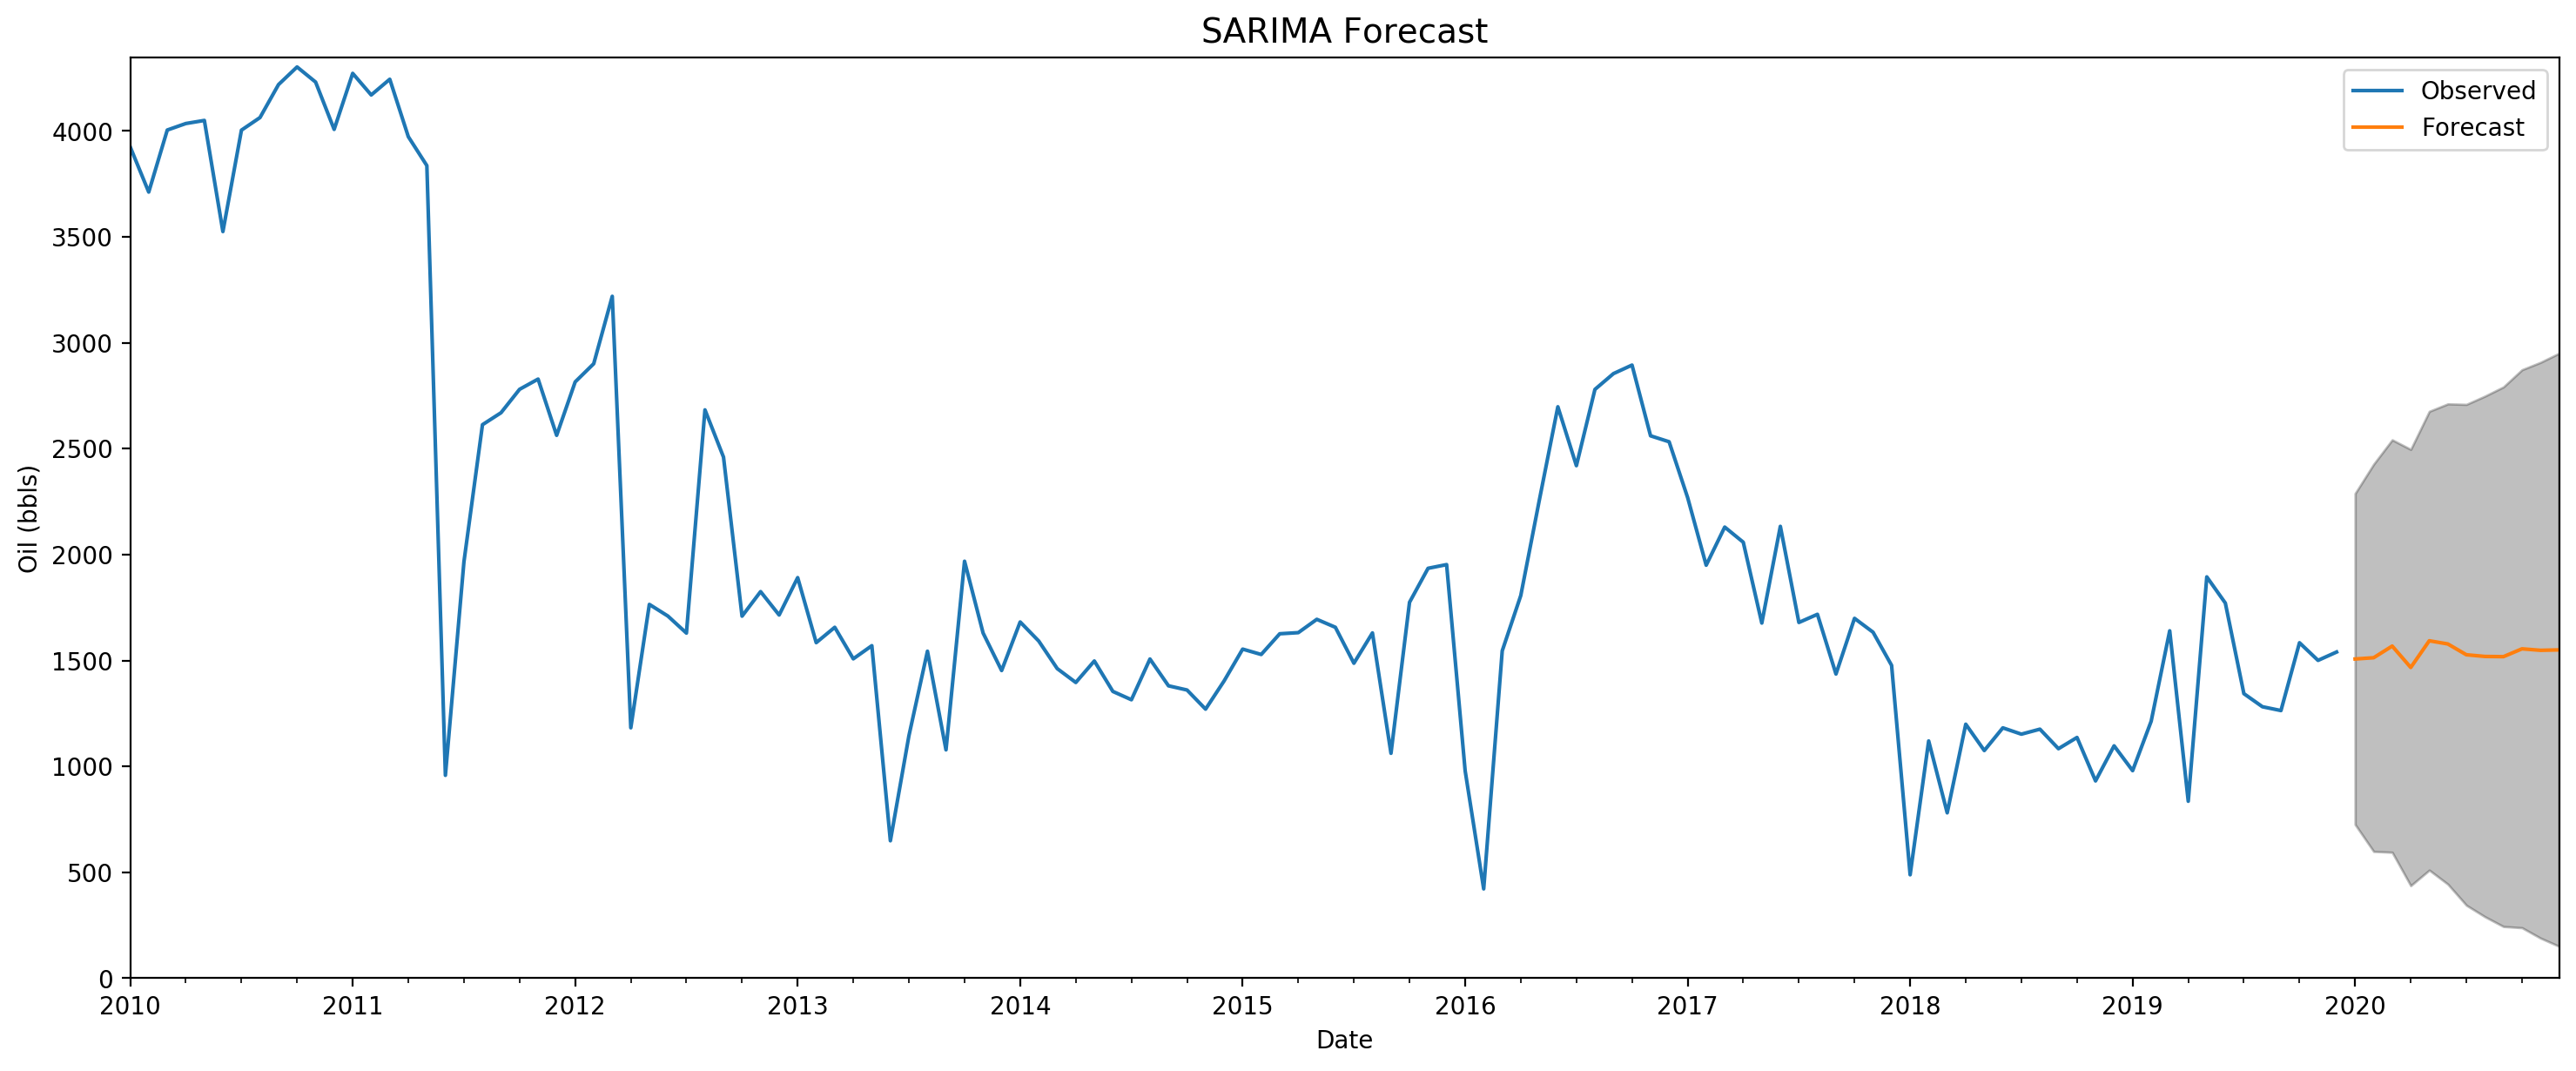

In [43]:
# Plot ARIMA results
plt.figure(figsize=(18, 7), dpi=200)
ax = series_data.plot(label='Observed')
y_forecasted.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.ylim((0, y_max))
plt.title('SARIMA Forecast', fontsize=14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Oil (bbls)', fontsize=10)
plt.legend()
plt.show()

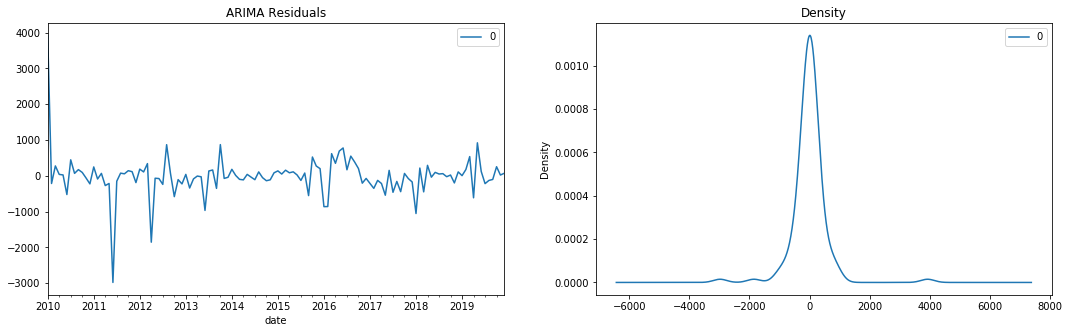

In [44]:
# Plot ARIMA residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
residuals.plot(title="ARIMA Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.legend()
plt.show()

#### Result
- RMSE: 1.567
- MAPE: 24.816 %
- AIC: 253.837
- BIC: 261.938
- Elapsed Time: 90m

## 5. Holt-Winters Analysis

**Exponential smoothing** is a time series forecasting method for univariate data that can be extended to support data with a systematic trend or seasonal component.

There are three types of exponential smoothing; they are:
- Single Exponential Smoothing, or SES, for univariate data without trend or seasonality.
- Double Exponential Smoothing for univariate data with support for trends.
- Triple Exponential Smoothing, or **Holt-Winters** Exponential Smoothing, with support for both trends and seasonality.

We will use the implementation of <a href="https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html" target="_blank">Holt-Winters Exponential Smoothing</a> provided by the statsmodels library.

### 5.1. Select best parameters for Holt-Winters model

This model has hyperparameters that control the nature of the exponential performed for the series, trend, and seasonality, specifically:
- **smoothing_level** (alpha): the smoothing coefficient for the level.
- **smoothing_slope** (beta): the smoothing coefficient for the trend.
- **smoothing_seasonal** (gamma): the smoothing coefficient for the seasonal component.
- **damping_slope** (phi): the coefficient for the damped trend.

There are other hyperparameters that the model will not automatically tune that you may want to specify; they are:
- **trend**: The type of trend component, as either “add” for additive or “mul” for multiplicative. Modeling the trend can be disabled by setting it to None.
- **damped**: Whether or not the trend component should be damped, either True or False.
- **seasonal**: The type of seasonal component, as either “add” for additive or “mul” for multiplicative. Modeling the seasonal component can be disabled by setting it to None.
- **seasonal_periods**: The number of time steps in a seasonal period, e.g. 12 for 12 months in a yearly seasonal structure.
- **use_boxcox**: Whether or not to perform a power transform of the series (True/False) or specify the lambda for the transform.

In [45]:
# Create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    
    # Define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    
    models = list(itertools.product(t_params, d_params, s_params, p_params, b_params, r_params))
    
    return models

In [46]:
# Split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [47]:
# One-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t, d, s, p, b, r = config
    
    # define model
    history = np.array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    
    # Fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    
    # Make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    
    return yhat[0]

# Walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    
    # Split dataset
    train, test = train_test_split(data, n_test)
    
    # Seed history with training dataset
    history = [x for x in train]
    
    # Step over each time-step in the test set
    for i in range(len(test)):
        
        # Fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        
        # Store forecast in list of predictions
        predictions.append(yhat)
        
        # Add actual observation to history for the next loop
        history.append(test[i])
    
    # Round predictions
    predictions = np.array([round(p) for p in predictions])
    
    # Estimate prediction error
    rmse = calc_rmse(test, predictions)
    mape = calc_mape(test, predictions)
    
    return rmse, mape

# Score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    rmse, mape = None, None
    
    # Convert config to a key
    key = str(cfg)
    
    # Show all warnings and fail on exception if debugging
    if debug:
        rmse, mape = walk_forward_validation(data, n_test, cfg)
    else:
        # One failure during model validation suggests an unstable config
        try:
            # Never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                rmse, mape = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
            
    # Check for an interesting result
    if rmse is not None or mape is not None:
        print(' > Model %s, RMSE %.3f, MAPE %.3f' % (key, rmse, mape))
    
    return (key, rmse, mape)

# Run grid search configs
def hw_grid_search(data, param_list, n_test, parallel=True):
    scores = None
    
    if parallel:
        # Execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in param_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in param_list]
        
    # Remove empty results
    scores = [r for r in scores if r[1] is not None or r[2] is not None]
    
    # Sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    
    return scores

#### Run the grid search

In [48]:
# Run Holt-Winters fit
if run_fit:
    start_time = timeit.default_timer()
    
    # Calculation params
    param_list = exp_smoothing_configs([0, 13, 52])
    n_test = int(len(series_data.values) * perc_test)
    parallel = False
    
    # Grid search
    scores = hw_grid_search(series_data.values, param_list, n_test, parallel)
    print('Done Holt-Winters method')
    
    # Elapsed time
    elapsed = timeit.default_timer() - start_time
    print('Elapsed time', elapsed, 's')
    
    # List top 10 configs
    for cfg, rmse, mape in scores[:10]:
        print(cfg, rmse, mape)

### 5.2. Create Holt-Winters model

In [49]:
# Fitting a Holt-Winters Time Series model
history = series_data.values
model = ExponentialSmoothing(history, trend='mul', damped=False, seasonal='mul', seasonal_periods=13)
model = model.fit(optimized=True, use_boxcox=False, remove_bias=False)

In [50]:
print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  120
Model:             ExponentialSmoothing   SSE                       21535179.216
Optimized:                         True   AIC                           1485.725
Trend:                   Multiplicative   BIC                           1533.112
Seasonal:                Multiplicative   AICC                          1493.325
Seasonal Periods:                    13   Date:                 Thu, 09 Jul 2020
Box-Cox:                          False   Time:                         16:58:51
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5631194                alpha                 True
smoothing_slope          

### 5.3. Producing and visualizing forecasts

In [51]:
# Get forecast 52 steps ahead in future (1 year)
pred_hw = model.forecast(steps=n_forecast)
pred_hw = np.array([round(p) for p in pred_hw])

# Get confidence intervals of forecasts
pred_df = pd.DataFrame(pred_hw, columns=['forecast'])
pred_df = pred_df.set_index(pred_uc.predicted_mean.index)
pred_df['ci_inf'] = pred_hw * (1-ci_alpha/2)
pred_df['ci_sup'] = pred_hw * (1+ci_alpha/2)
pred_df.head()

,forecast,ci_inf,ci_sup
2020-01-31,1489.0,818.95,2159.05
2020-02-29,1161.0,638.55,1683.45
2020-03-31,1222.0,672.10,1771.90
2020-04-30,1366.0,751.30,1980.70
2020-05-31,1193.0,656.15,1729.85


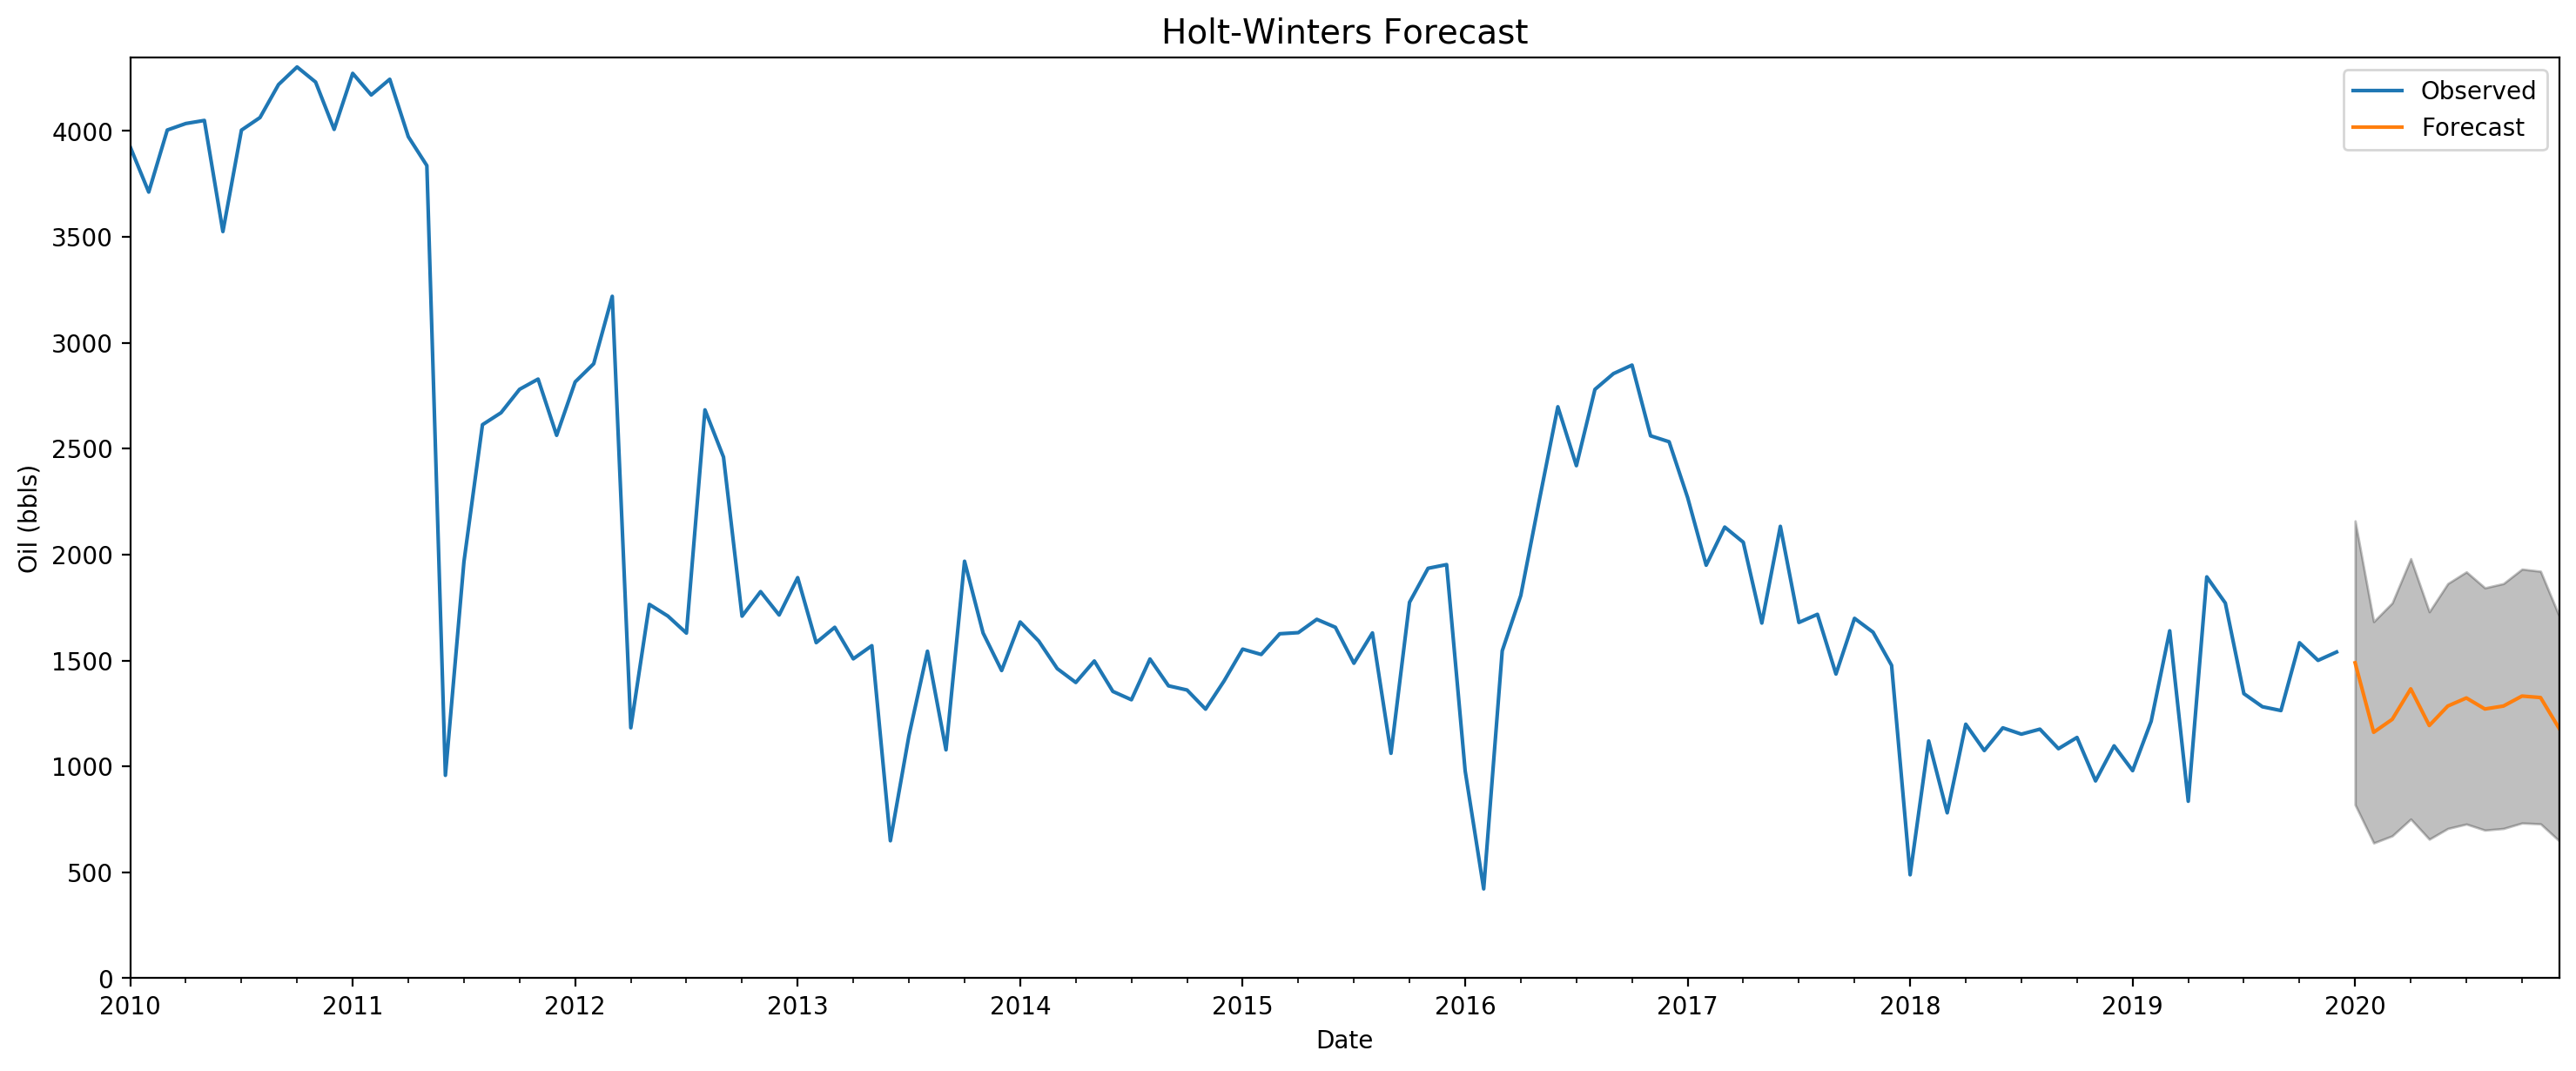

In [52]:
# Plot results
plt.figure(figsize=(18, 7), dpi=200)
ax = series_data.plot(label='Observed')
pred_df.forecast.plot(ax=ax, label='Forecast')
ax.fill_between(pred_df.index, pred_df.ci_inf, pred_df.ci_sup, color='k', alpha=.25)
plt.ylim((0, y_max))
plt.title('Holt-Winters Forecast', fontsize = 14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Oil (bbls)', fontsize=10)
plt.legend()
plt.show()

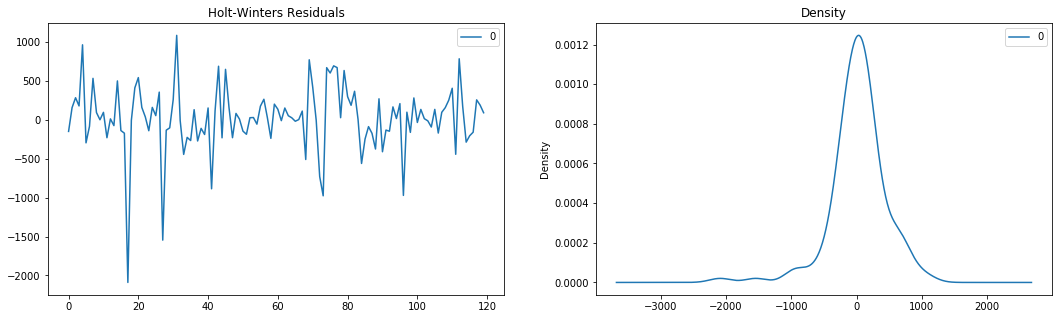

In [53]:
# Plot Holt-Winters residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
residuals.plot(title="Holt-Winters Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.legend()
plt.show()

#### Result
- RMSE: 2.045
- MAPE: 36.504
- AIC: 251.269
- BIC: 297.483
- Elapsed Time: 15m

## 6. Compare Models

In [54]:
# Set normalized data
df = pd.DataFrame({
    'group': ['ARIMA','HW'],
    'rmse': [0.522, 0.682],
    'mape': [0.496, 0.730],
    'aic': [0.846, 0.838],
    'bic': [0.873, 0.992],
    'time': [0.900, 0.150]
})

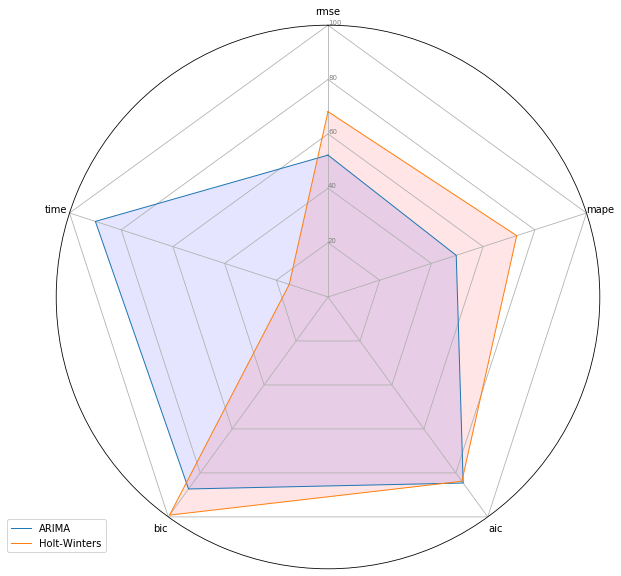

In [55]:
# PART 1: Create background
# Number of variable
categories = list(df)[1:]
num_vars = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Pentagon instead of circle
gridlines = ax.yaxis.get_gridlines()
for gl in gridlines:
    gl.get_path()._interpolation_steps = num_vars

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1], ["20","40","60", "80", "100"], color="grey", size=7)
plt.ylim(0, 1)

# PART 2: Add plots 
# Ind1
values = df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="ARIMA")
ax.fill(angles, values, 'b', alpha=0.1)

# Ind2
values = df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Holt-Winters")
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

---
End of analysis